***
# HCI Week 3 - Coronagraphs Part I
*Matthew Kenworthy // Leiden Observatory*
***

Today, in [*Questions 3.1*](#part1) *- 3.5*, we will go though the steps of determining encircled energy as a function of radius for a circular telescope pupil:
> *Step 1: Create the telescope pupil*<br>
> *Step 2: Conserving flux from Pupil to Focal Planes*<br>
> *Step 3: Calculating encircled energy as a function of radius*

Thereafter, in [*Questions 3.6*](#part2) *- 3.16*, you will simulate you own simple Lyot coronagraph. 

For a cool NASA animation on how a Lyot Coronograph works, see [this link](https://exoplanets.nasa.gov/resources/2130/coronagraph-explanation-2-minutes/).


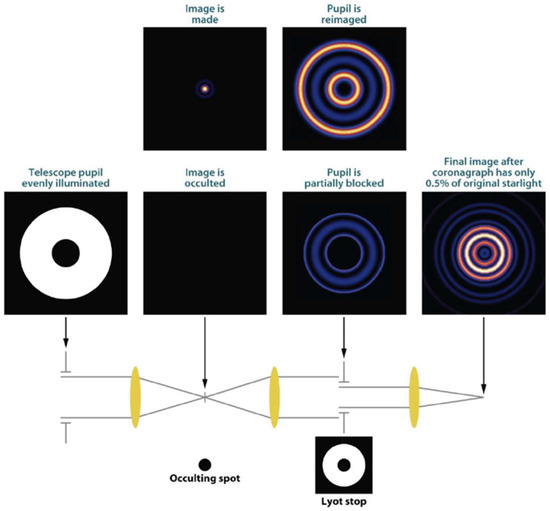
[Image credits: geoSciences](https://www.mdpi.com/journal/geosciences/special_issues/extrasolar_planets)

<div class="alert alert-block alert-info">
<b>Tip:</b> Read through the functions defined in the block below, as they may help with the exercises.</div>


Load Python modules into the notebook:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' 

import matplotlib as mpl
mpl.rc('image', interpolation='nearest', origin='lower')

Load in some functions we will use later: `displC`, `padcplx`, `FFT`, `IFFT`, `circle_mask`, `phi_ramp` and `logit`

In [2]:
def displC(c,trim=0):
    """displC - display a Complex number c as four plots
    
               The top two plots are (Real, Imaginary) quantities
               The bottom two plots are (Amplitude, Phase)
               
               Optionally cut out the central square  with a size of 'trim x trim' pixels"""   
    c2 = np.copy(c)
    if (trim>0): # if the user specifies a trim value, cut out the centre of the image
        (nx,ny) = c.shape
        dx = int((nx-trim) / 2 + 1)
        dy = int((nx-trim) / 2 + 1)
        c2 = c[dx:dx+trim,dy:dy+trim]
        
    # set up the plot panels
    fig=plt.figure(figsize=(10,8))
    axre = fig.add_subplot(221)
    axim = fig.add_subplot(222)
    axamp = fig.add_subplot(223)
    axpha = fig.add_subplot(224)
    # plot out the panels
    im = axre.imshow(c2.real)
    im = axim.imshow(c2.imag)
    im = axamp.imshow(np.abs(c2))
    im = axpha.imshow(np.angle(c2))
    
    axre.set_title('Real')
    axim.set_title('Imag')
    axamp.set_title('Amplitude')
    axpha.set_title('Phase')
    plt.show()

def padcplx(c,pad=5):
    """padcplx - puts a `Complex` array into the centre of a zero-filled `Complex` array
               pad is an integer defining the padding multiplier for the output array """
    (nx, ny) = c.shape
    bignx = nx*pad
    bigny = ny*pad
    big_c = np.zeros((bignx,bigny),dtype=complex)

    dx = np.array((nx * (pad-1)) / 2).astype(int)
    dy = np.array((ny * (pad-1)) / 2).astype(int)

    big_c[dx:dx+nx,dy:dy+ny] = c
    return(big_c)

def FFT(c,pad=5):
    """FFT - carry out a complex Fourier transform (with optional padding)
            c - the input 2D Complex numpy array
            pad - integer multiplier for the padding/sampling
            Returns the `Complex` FFT padded array"""
    from numpy.fft import fft2,fftshift,ifft2,ifftshift
    psfA = fftshift(fft2(ifftshift(padcplx(c,pad))))
    return psfA

def IFFT(c,pad=5):
    """IFFT - carry out the complex Fourier transform (with optional padding)
            and return the FFT padded array"""
    from numpy.fft import fft2,fftshift,ifft2,ifftshift
    psfA = fftshift(ifft2(ifftshift(padcplx(c,pad))))
    return psfA

def circle_mask(im, xc, yc, rcirc):
    """circle_mask - function that takes the input 2D array 'im' that evaluates the equation 
            (x-x_c)^2 + (y-y_c)^2 < r^2 with circle center coordinates (x_c, y_c) and a radius 'r'
            as input parameters and return a mask array with the same shape as 'im'."""
    ny, nx = im.shape
    y,x = np.mgrid[0:nx,0:ny]
    r = np.sqrt((x-xc)*(x-xc) + (y-yc)*(y-yc))
    return ( (r < rcirc))
    

def r_theta(im, xc, yc):
    """r_theta - make a radius mask and return the radius rr and the angle phi for point (xc,yc)"""
    ny, nx = im.shape
    yp, xp = np.mgrid[0:ny,0:nx]
    yp = yp - yc
    xp = xp - xc
    rr = np.sqrt(np.power(yp,2.) + np.power(xp,2.))
    phi = np.arctan2(yp, xp)
    return(rr, phi)

def phi_ramp(im, npx, npy):
    """phi_ramp - make an X-ramp, making the 0 be in the middle, make it -0.5 to +0.5 and make it -pi to +pi. """
    ny, nx = im.shape
    ly = np.linspace(-0.5, 0.5, ny) * np.pi * npy * 2
    lx = np.linspace(-0.5, 0.5, nx) * np.pi * npx * 2
    
    x, y = np.meshgrid(lx, ly) 
    return(x+y)

def logit(im, minlog=-6):
    """logit - takes the log10 of an image and rounds up tiny logs to minlog so that displC()
            works better. """
    imout = np.copy(im)
    logimout = np.log10(imout)
    logimout[(logimout<minlog)] = minlog
    return(logimout)

<a id='part1'></a>

## Step 1: Create the telescope pupil

The first stage in the process of creating our Lyot coronograph is to make a telescope pupil. The pupil is circular with no central obscuration. In a square grid we can simulate this circular pupil using a circular mask. Be aware that the circle must touch all 4 sides of the square. 

---
<span style="  font-size:2em; color: SteelBlue;">Question 3.1</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Make a telescope pupil with a diameter of 101 pixels. The pupil is circular with no central obscuration, and the circle must touch all 4 sides of the square. Turn the circular pupil into complex amplitude pupil with an amplitude per pixel of 1 and zero phase. Call this the telescope pupil `A`.**

---

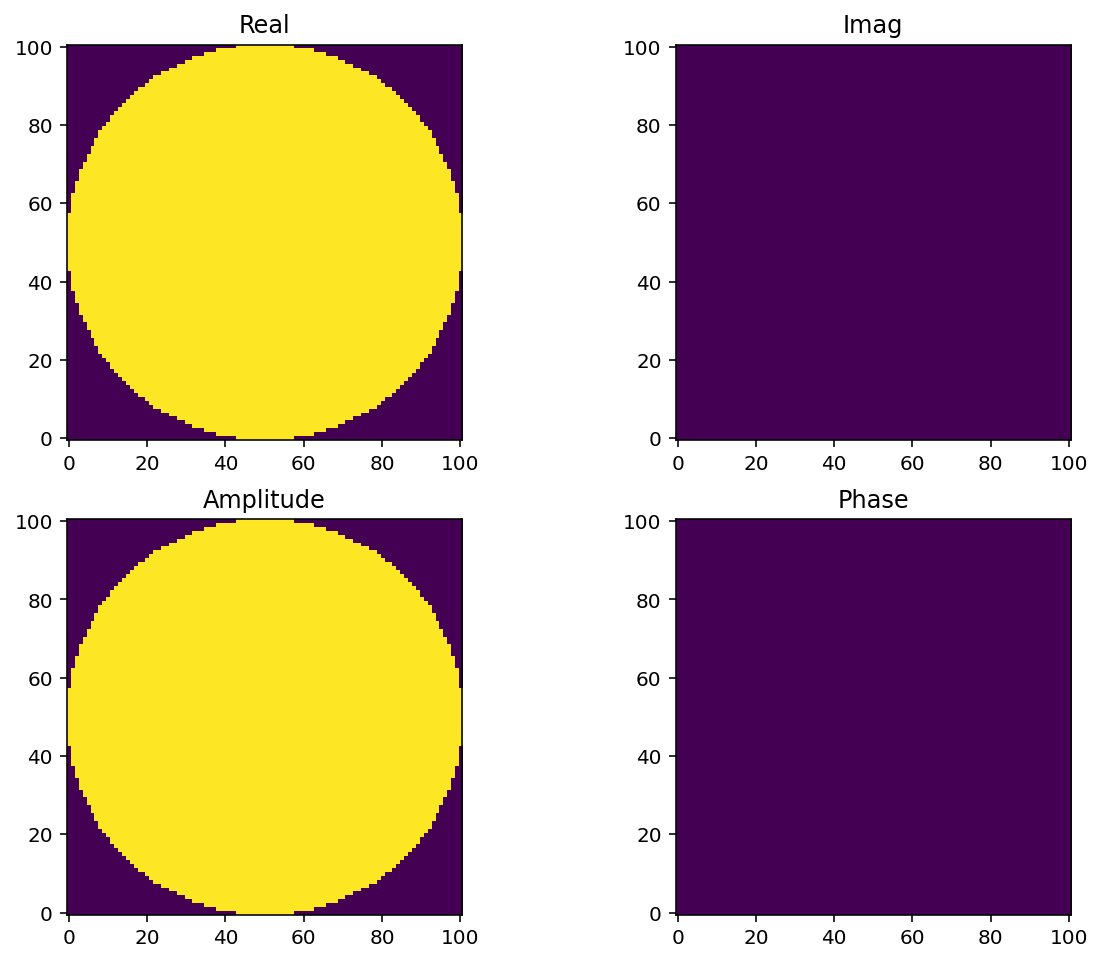

In [3]:
dtel = 101 # pixels

# Q1 answer here
y,x = np.mgrid[:dtel, :dtel]

ampli = np.ones_like(y)
phase = np.zeros_like(y)  # zero phase across entire aperture

# make the complex amplitude E
E = ampli * np.exp(1j*phase)
msk = circle_mask(E,50,50,dtel/2)
A  = E.copy()
A[msk==0]=0
# Q1 end of answer

displC(A)

## Step 2: Conserving flux from Pupil to Focal Planes

We should normalise the ***intensity*** of the telescope pupil to a value of 100.0 intensity units. Recall from last week that you can calculate the intensity as seen on a detector $I_{det}$ by calculating the modulus squared of the electric field on the detector: $$I_{det} = \|E_{det}\|^2 = E_{det} \cdot \text{conj}(E_{det}) = \texttt{np.abs(E)} * \texttt{np.abs(E)}$$

---
<span style="  font-size:2em; color: SteelBlue;">Question 3.2</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

1. **Write your own subroutine, `Isum()`, to calculate the summed** ***intensity*** **of a complex amplitude input image. <br>The subroutine should return a real number.**

<div class="alert alert-block alert-info">
<b>Hint:</b>  look up <code>np.conjugate</code> and <code>np.real</code></div>

2. **Use `Isum()` to normalise the telescope pupil `A`. Recall that `A` was the complex amplitude. <br>Normalise this pupil `A` such that `Isum(A) = 100.0`.**

<div class="alert alert-block alert-info">
<b>Hint:</b>  Remember that the intensity is the square of the amplitude.....
$$I = A^2$$</div>



---

In [4]:
# Q2 answer here

def Isum(c):
    amp = np.abs(c)
    I = np.sum(amp**2)
    return  I

# normalise A
norm = Isum(A)
A = A*np.sqrt(1e2/norm)
# Q2 end of answer

print("The value for Isum(A) = ", Isum(A))

The value for Isum(A) =  100.00000000000003


---
<span style="  font-size:2em; color: SteelBlue;">Question 3.</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>
**Calculate the Amplitude Spread Function (ASF) for this telescope pupil with a sampling of 7 (use the variable `nsamp = 7` to hold this, as you may want to easily change this value later on). Call the new complex amplitude `B`.**

1. **Print out the `Isum()` of `B`.**

Since energy is conserved, your intuition tells you that you should get `Isum(B) = 100.0` - but you don't. Instead it's a much higher number. There is a normalisation factor that will get you back to `100.0`, and you can calculate it from one of the properties your input `A`.

2. **Show that you have normalised B correctly by making `Bn` be the correctly normalised version of `B` and show `Isum(Bn) = 100.0`**


<div class="alert alert-block alert-info">
<b>Hint:</b> It's related to how the FFT routine works, and involves a very simple quantity associated with all `numpy` arrays. Look at the `numpy` documentation for all properties associated with a defined numpy variable, and also look at what the scaling factor appears to be.</div>

---


In [5]:
nsamp = 7

# Q3 answer here
B = FFT(A,pad=nsamp)
print("The value for Isum(B) = ", Isum(B))
# normalise Bn
norm = nsamp**2*A.shape[0]**2
Bn = B/np.sqrt(norm)

# Q3 end of answer

print("The value for Isum(Bn) = ", Isum(Bn))

The value for Isum(B) =  49984899.999999985
The value for Isum(Bn) =  99.99999999999999


## Step 3: Calculating encircled energy as a function of radius
We learned in last weeks lecture that imaging a point source with a telescope shows a diffraction pattern. This is due to the finite size of telescope aperture and wavelike nature of light. The energy of the star (or planet) is spread out over the focal plane in an Airy disk of radius $1.22 \lambda / D$, where our sampling `nsampl` is equal to $\lambda / D$.

---
<span style="  font-size:2em; color: SteelBlue;">Question 3.4</span> <span style="  font-size:1em; color: SteelBlue;">
(4 points): </span>

**Write a routine  `ee(im, xap, yap, r_ap)` to calculate the fraction of encircled energy within a circular aperture of radius `r_ap` centered at `(xap, yap)` in a complex image `im`.<br>To improve efficiency, make it so that `r_ap` can be a numpy array of radii, and use a `for` loop with `enumerate()` to return a numpy array of encircled energy values.**


<div class="alert alert-block alert-info">
<b>Hint:</b> Look at the routine <code>r_theta()</code> at the start of the Practicum </div>

---


In [6]:
def ee(im, xap, yap, r_ap):
    """ee - calculate the fraction of encircled energy within a circular aperture of radius 'r_ap'
            centered at (xap, yap) in the complex imput image 'im'. Returns encircled energy"""
    # Q4 answer here
    frac = np.zeros_like(r_ap)
    
    for i,ri in enumerate(r_ap):
        nsamp = 7
        msk  = circle_mask(im,xap,yap,ri)
        val = im.copy()
        val[msk==0]=0
        frac[i]=np.sum(np.real(val)**2)
    return frac
    
    

    # Q4 end of answer

---
<span style="  font-size:2em; color: SteelBlue;">Question 3.5</span> <span style="  font-size:1em; color: SteelBlue;">
(6 points): </span>

**Plot out the encircled energy `EEout` versus increasing aperture radii `incrAp` for the PSF in `B`.**
1. **Starting with a radius of 1 pixel, go in steps of 1 pixel out to $10 \lambda/D$. Label the x-axis of the plot in unit of $\lambda/D$.** <br>*(Yes, I know I'm changing units on you!)*
* **Plot a vertical line at a radius of $1.22 \lambda/D$.**
* **Answer the question: What is the *fraction* of the total energy enclosed within a radius of $1.22 \lambda/D$?** 

<div class="alert alert-block alert-info">
<b>Sanity Check:</b>  What should the EE be for very large radii?</div>

---


The fraction of encircled energy at 1 l/D is: 83


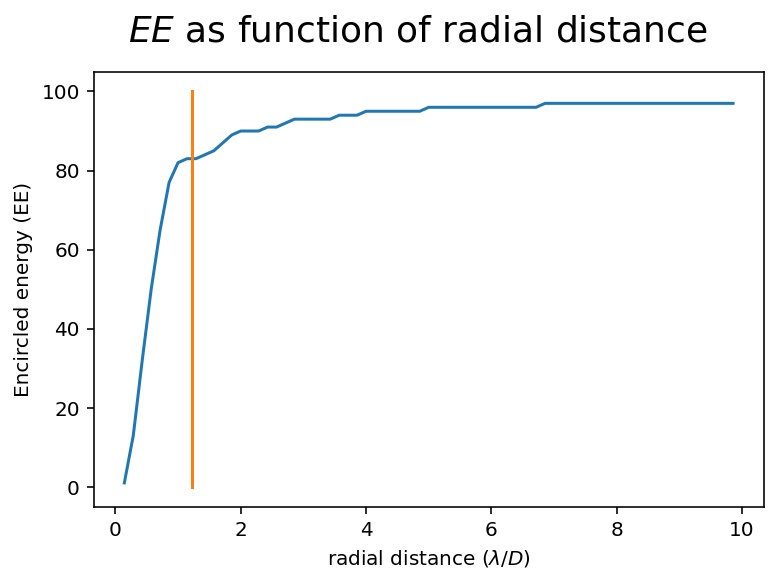

In [7]:
# Q5 answer here

# ....
nsamp=7
r_ap = np.arange(1,10*nsamp,1)
EEout = ee(Bn,353,353,r_ap)
incrAp = r_ap/nsamp
ind = np.argmin(np.abs(incrAp-1.22))
fraction = EEout[ind]


# Q5 end of answer

print('The fraction of encircled energy at 1 l/D is:', fraction)

fig, ax = plt.subplots(1, figsize=(6,4))  

ax.plot(incrAp,EEout)
ax.plot(np.array([1.22,1.22]),np.array([0,100]))

ax.set_xlabel('radial distance $(\lambda/D)$')                 
ax.set_ylabel('Encircled energy (EE)')               
fig.suptitle('$EE$ as function of radial distance', fontsize=18) 
plt.show()

<a id='part2'></a>

## From telescope pupil to Coronagraph Simulator

Here is a simple optical layout of a telescope, coronagraph, and science imaging camera. The figure is taken from [Sivaramakrishnan and Oppenheimer (2006)](http://adsabs.harvard.edu/abs/2006ApJ...647..620S).

<img src="coronagraph.png">


  * A is the telescope entrance pupil
  * B is the first focal plane
  * $m(k)$ is the focal plane coronagraphic mask
  * C is the masked first focal plane
  * D is the Lyot pupil plane
  * $N(x)$ is the Lyot pupil plane coronagraphic mask
  * E is the masked Lyot plane
  * F is the final focal plane
  
Many types of coronagraph can be specified with $m(k)$ and $N(x)$, resulting in attenuation for on-axis sources whilst letting as much light from a nearby companion through.

The axis of the coronagraph is at  the central pixel `xcen,ycen` of `B`, `C` and `F`, and we will refer to this pixel as being at the origin, i.e. $(x,y)=(0,0)$ for the central pixel.

---

> This week we will make a Lyot coronagraph and compare its efficiency at transmitting and rejecting light compared to direct imaging. We define the function `coro()` which produces the final science camera focal plane image `F` and all the intermediate planes. 

In [8]:
def coro(A, m, N, nsamp):
    """coro - simulated Lyot coronograph taking a telescope pupil 'A', transmissive masks 'm' and 'N'
            and a sampling number 'nsamp' that returns  the final science camera focal plane image 'F' 
            and all the intermediate planes."""
    B = FFT(A,nsamp)
    #normalize B according to previous found relation
    norm = nsamp**2*A.shape[0]**2
    B = B/np.sqrt(norm)
    C = m * B
    D = IFFT(C,1)
    E = N * D
    F = FFT(E,1)
    
    return(B,C,D,E,F)

First things first - let's see that `coro()` works by putting in two fully transmissive masks for `m` and `N`. Remember that both masks will have to be padded to the same size as `B` in order for `coro()` to work. 

---
<span style="  font-size:2em; color: SteelBlue;">Question 3.6</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span> 

**Use the telescope pupil `A` with `Isum = 100.0` and `nsamp=7`, and show that the `Isum` of `B`,`C`,`D`,`E` and `F` are all equal to `100.0` (or at least very close to this, depending on numerical precision).**


<div class="alert alert-block alert-info">
<b>Hint:</b>  Remember that you will have to correct the intensities according to the relation you found out earlier in the notebook.</div>

---

In [9]:
# Q6 answer here

# ....
nsamp=7
m = np.ones((A.shape[0]*nsamp,A.shape[0]*nsamp))
N = m.copy()

B,C,D,E,F = coro(A,m,N,nsamp)
#norm = nsamp**2*A.shape[0]**2
#B = B/np.sqrt(norm)
#C = C/np.sqrt(norm)
#F = F/np.sqrt(norm)

Alyot = Isum(A)
Blyot = Isum(B)
Clyot = Isum(C)
Dlyot = Isum(D)
Elyot = Isum(E)
Flyot = Isum(F)

# Q6 end of answer

# Check the throughput

print('Throughput: A={:.2f} B={:.2f} C={:.2f} D={:.2f} E={:.2f} F={:.2f}'.format(Alyot,Blyot,Clyot,Dlyot,Elyot,Flyot))

Throughput: A=100.00 B=100.00 C=100.00 D=0.00 E=0.00 F=100.00


We put the star we wish to block on the central axis of the coronagraph - this is done already with telescope pupil `A`, normalised to `Isum(A) = 100.0`.

---
<span style="  font-size:2em; color: SteelBlue;">Question 3.7</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Make a copy of `A` using `np.copy()` and call it `A_star`, and use `coro()` to generate the ASF (i.e. keep it a complex amplitude all the way through the coronagraph!) at the first focal plane and call it `B_star`. Show the resultant PSF of the star in the first focal plane `B` using `displC(B_star, 151)`**

---

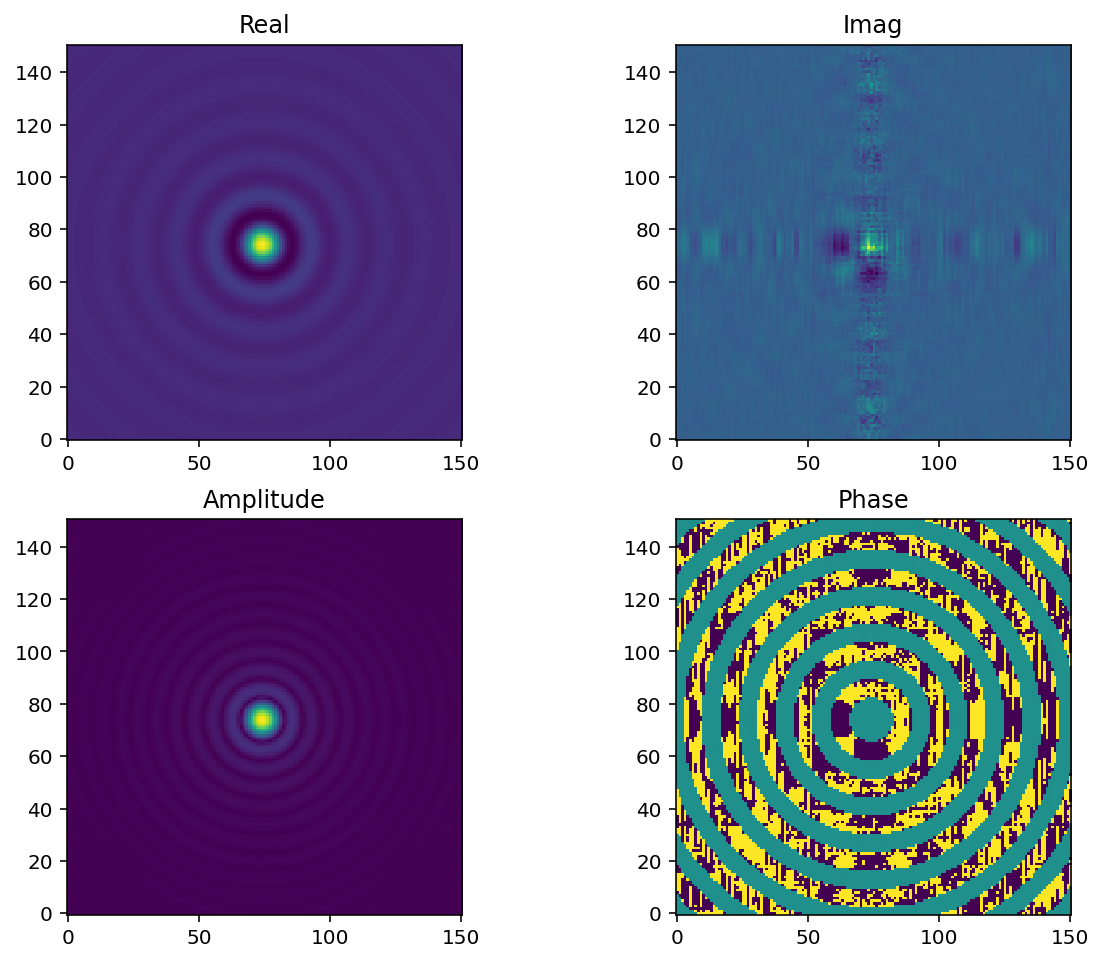

In [10]:
# Q7 answer here
A_star = A.copy()
B_star = coro(A_star,m,N,nsamp)[0]
displC(B_star,151)
# Q7 end of answer

We can now make a planet that is 10000 times fainter **in energy** than the star, and move it off the axis of the coronagraph by adding a tilt in phase across the telescope pupil.

---
<span style="  font-size:2em; color: SteelBlue;">Question 3.8</span> <span style="  font-size:1em; color: SteelBlue;">
(6 points): </span>

**Make a planet image that is $5 \lambda / D$ along the positive x-axis:**
1. **Make a copy of the star's telescope pupil**
2. **Add a suitable ramp of phase to the telescope pupil - call this `A_planet`** 
3. **Using `coro()` and `displC(B_planet, 151)` show that the resultant PSF of the planet in the first focal plane `B` is moved off of the central axis of the coronagraph.**


<div class="alert alert-block alert-info">
<b>Hint:</b> Go look at <code>phi_ramp()</code> and see what it's doing. </div>

---

The sum of energy of the planet is:  0.01


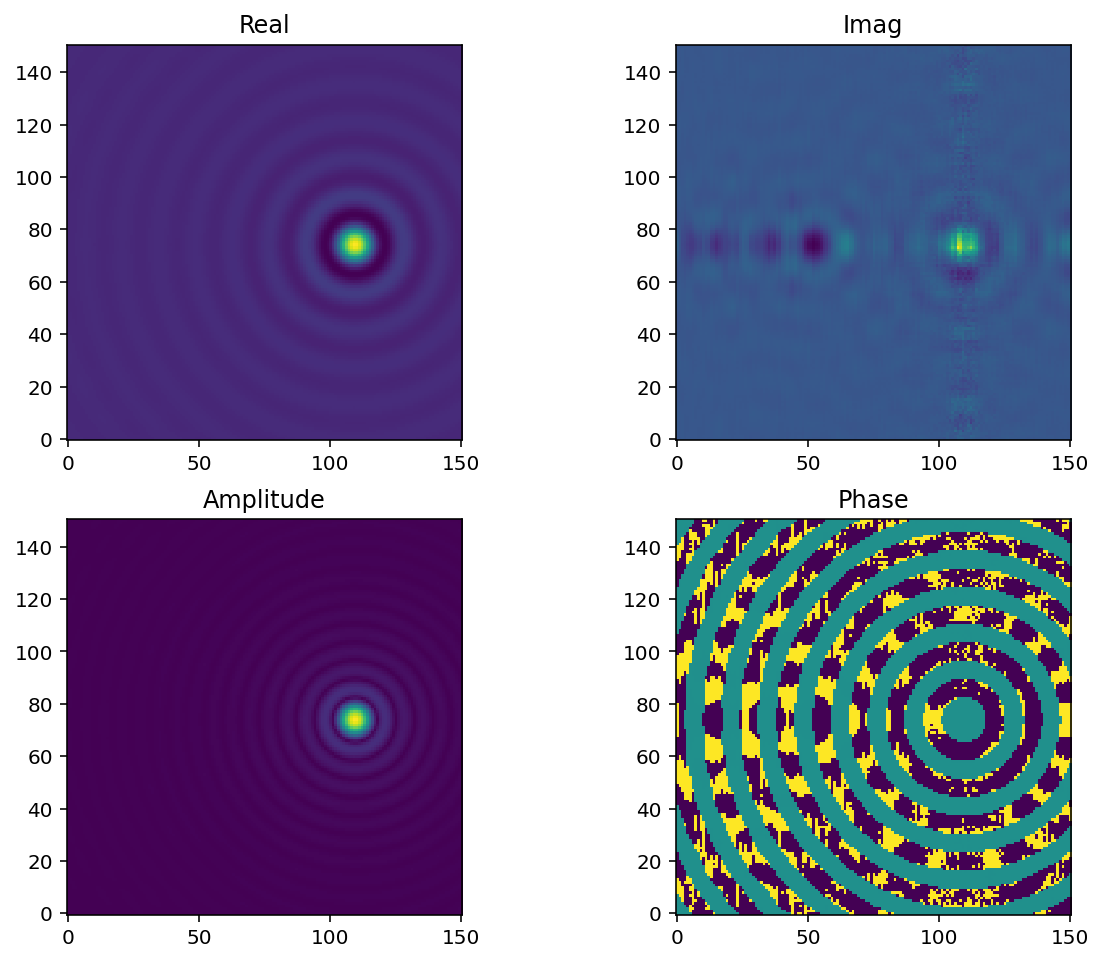

In [11]:
# Q8 answer here

Amp_planet = np.real(A_star.copy())/1e2
rp = phi_ramp(Amp_planet,5,0)
A_planet = Amp_planet * np.exp(1j*rp)
print("The sum of energy of the planet is: ",Isum(A_planet))
B_planet = coro(A_planet,m,N,nsamp)[0]
displC(B_planet,151)


The diffracted light from the star forms a **halo** of light in the science camera focal plane `F`. We can compare the halo of light from the star with the flux from the planet at the $5 \lambda / D$ location. We will do this by plotting the star's PSF and planet PSF and comparing relative fluxes.

---
<span style="  font-size:2em; color: SteelBlue;">Question 3.9</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Write a routine `xaxis_energy(im,xr)` that takes a complex image `im`, cuts out the line of pixels from -xr to +xr across the middle of the image (equivalent to $y=0$) and returns the *energy per pixel* along that line.**


---

In [12]:

def xaxis_energy(im, xr):
    """xaxis_energy - takes a complex image im, cuts out the line of pixels from -xr to +xr
            across the middle of the image and returns the energy per pixel along that line"""
    # Q9 answer here
    cent = int((im.shape[0]-1)/2)
    im_cut = im.copy()[:,cent-xr:cent+xr+1]
    energy = np.real(im_cut)**2
    return np.sum(energy,axis=0)
    # Q9 end of answer
#'''

We compare the **direct imaging** case first by looking at the PSFs of the star and the planet in the `B` values.

The peak of the PSF of the star is in the middle of the array `B_star`. 

---
<span style="  font-size:2em; color: SteelBlue;">Question 3.10</span> <span style="  font-size:1em; color: SteelBlue;">
(6 points): </span>

**Plot out the `log10` energy of the PSF centered on the axis of the coronagraph along the x axis from -10 to + 10 $\lambda/D$ . The x-axis should be labelled in units of $\lambda/D$.**  **Plot the planet's PSF on the same graph as the PSF of the star. Add a label to the plots and show them in a legend.**


<div class="alert alert-block alert-info">
<b>Sanity Check:</b>  You should see that the planet's peak flux is slightly below the stellar halo at $5 \lambda/D$.</div>

<div class="alert alert-block alert-info">
<b>Tip:</b>  You can simply add more than one plot to a graph by adding more plots in one axis using ax.plot(planet), ax.plot(star).</div>

---


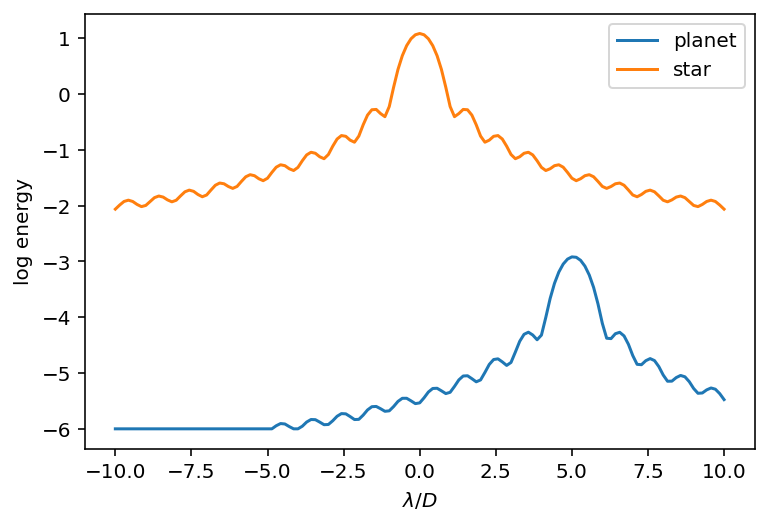

In [13]:
# Q10 answer here

energy_star = xaxis_energy(B_star,10*nsamp)
energy_planet = xaxis_energy(B_planet,10*nsamp)
x_ap = np.arange(-10*nsamp,10*nsamp+1,1)/nsamp
log10_star = logit(energy_star)
log10_planet = logit(energy_planet)
plt.plot(x_ap,log10_planet,label='planet')
plt.plot(x_ap,log10_star,label='star')
plt.xlabel('$\lambda/D$')
plt.ylabel('log energy')
plt.legend()
# Q10 end of answer

### Finally, let's put in a classical Lyot coronagraph!

A classical Lyot coronagraph consists of a hard-edged occulter in the first focal plane, followed by a Lyot stop in the second pupil (the Lyot) plane.

---
<span style="  font-size:2em; color: SteelBlue;">Question 3.11</span> <span style="  font-size:1em; color: SteelBlue;">
(4 points): </span>

**Make a hard edged mask `m_lyot` that has a radius of $3 \lambda/D$. It should have a transmission of 0 within this radius, and a transmission of 1 outside this radius. Assume there is no phase change with light passing through the mask.**

**Display the effect of the mask `m_lyot` on the planet's PSF `B_planet` by calculating `C_planet` and then use `displC(x, 151)`**

---


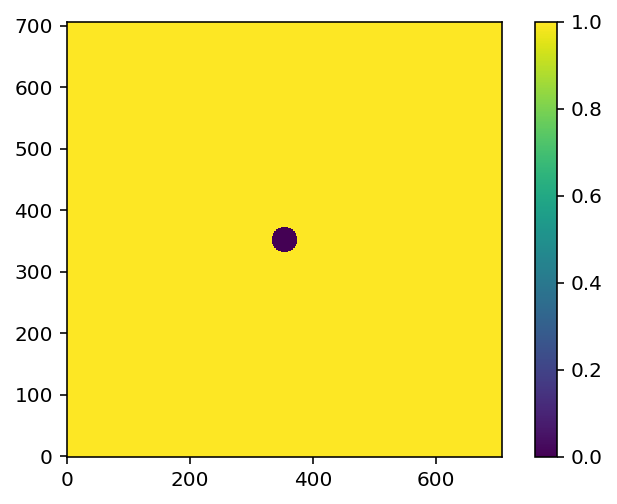

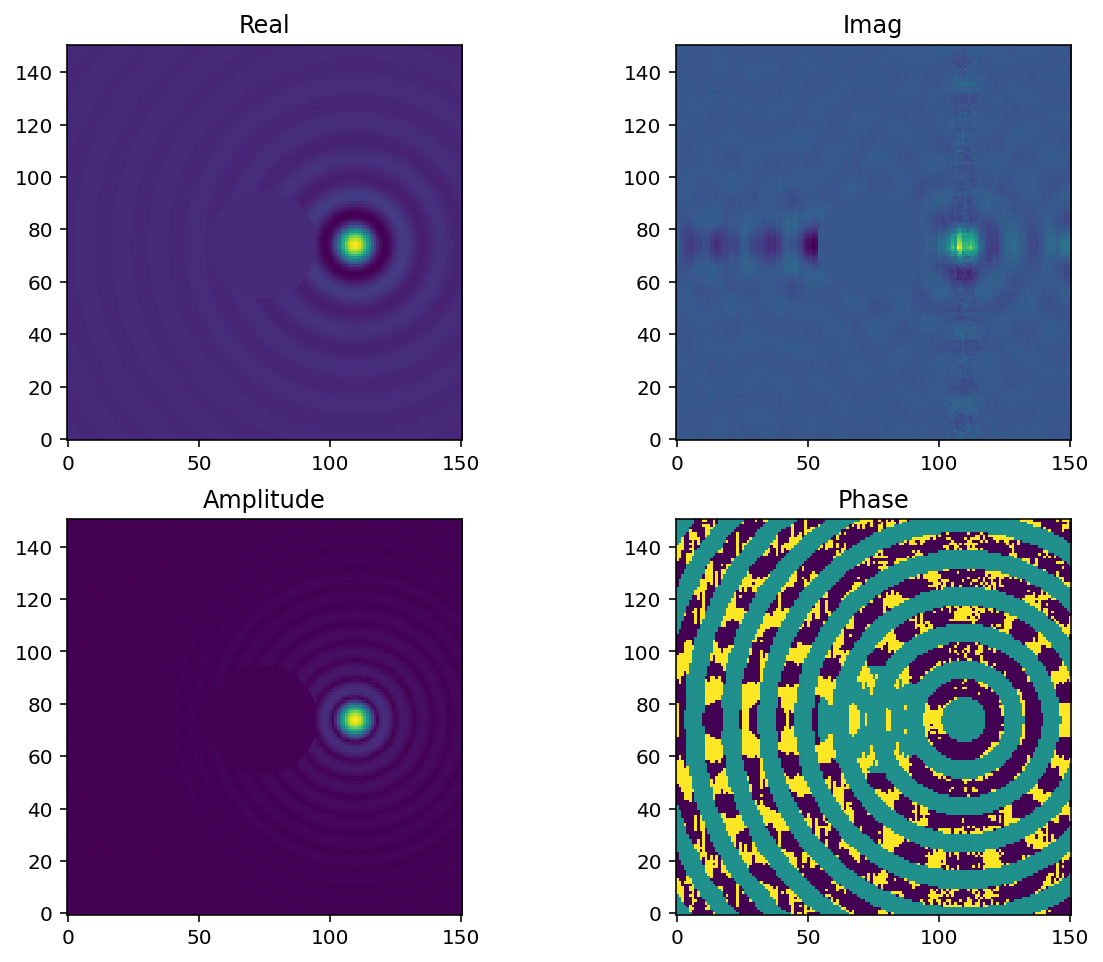

In [14]:
# Q11 answers here

m_lyot = circle_mask(B,int((B.shape[0]-1)/2),int((B.shape[0]-1)/2),3*nsamp)
plt.imshow(~m_lyot)
plt.colorbar()
C_planet = coro(A_planet,~m_lyot,N,nsamp)[1]
displC(C_planet,151)
# Q11 end of answer


---
<span style="  font-size:2em; color: SteelBlue;">Question 3.12</span> <span style="  font-size:1em; color: SteelBlue;">
(4 points): </span>

1. **Make the Lyot stop `N_lyot` so that it blocks all light outside 0.8 times the diameter of the pupil at location `D` in the coronagraph, and run the coronagraph simulator for both the star and the planet. Display the result using `displC(N_lyot)`**
2. **Make the same logarithmic energy plots with the same x-axis range for the final science camera plane `F_star` and `F_planet`.**

**Which object is brighter at $5 \lambda/ D$ now?**

---


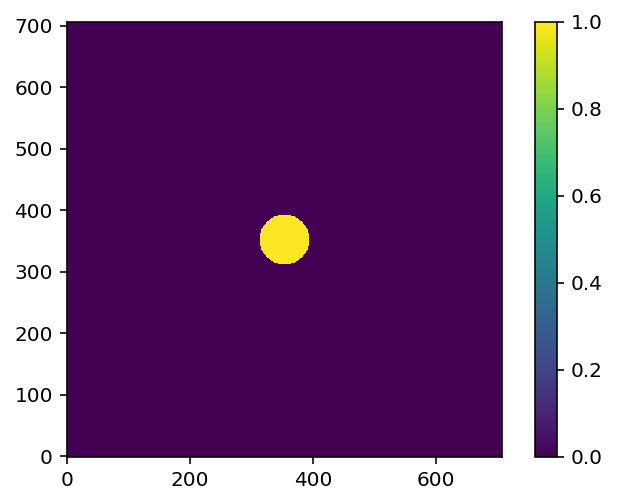

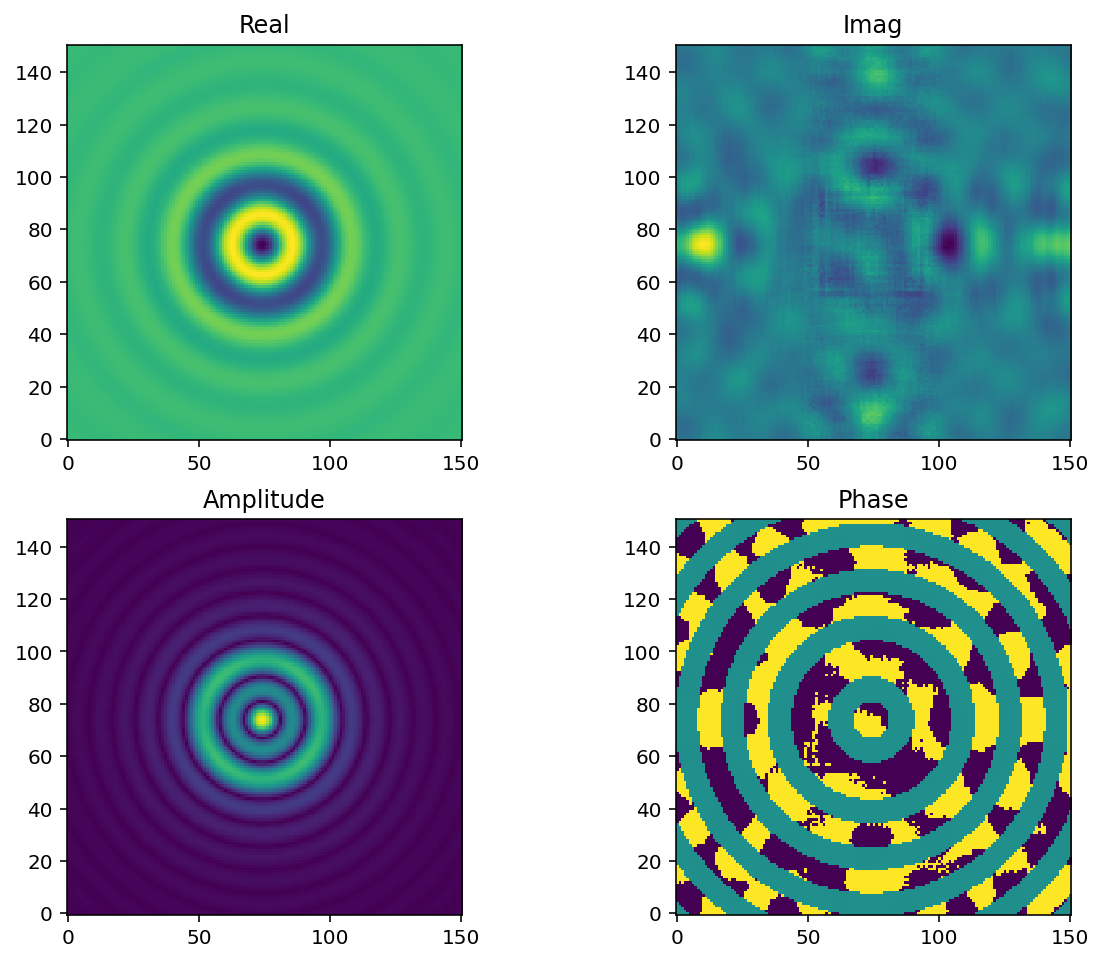

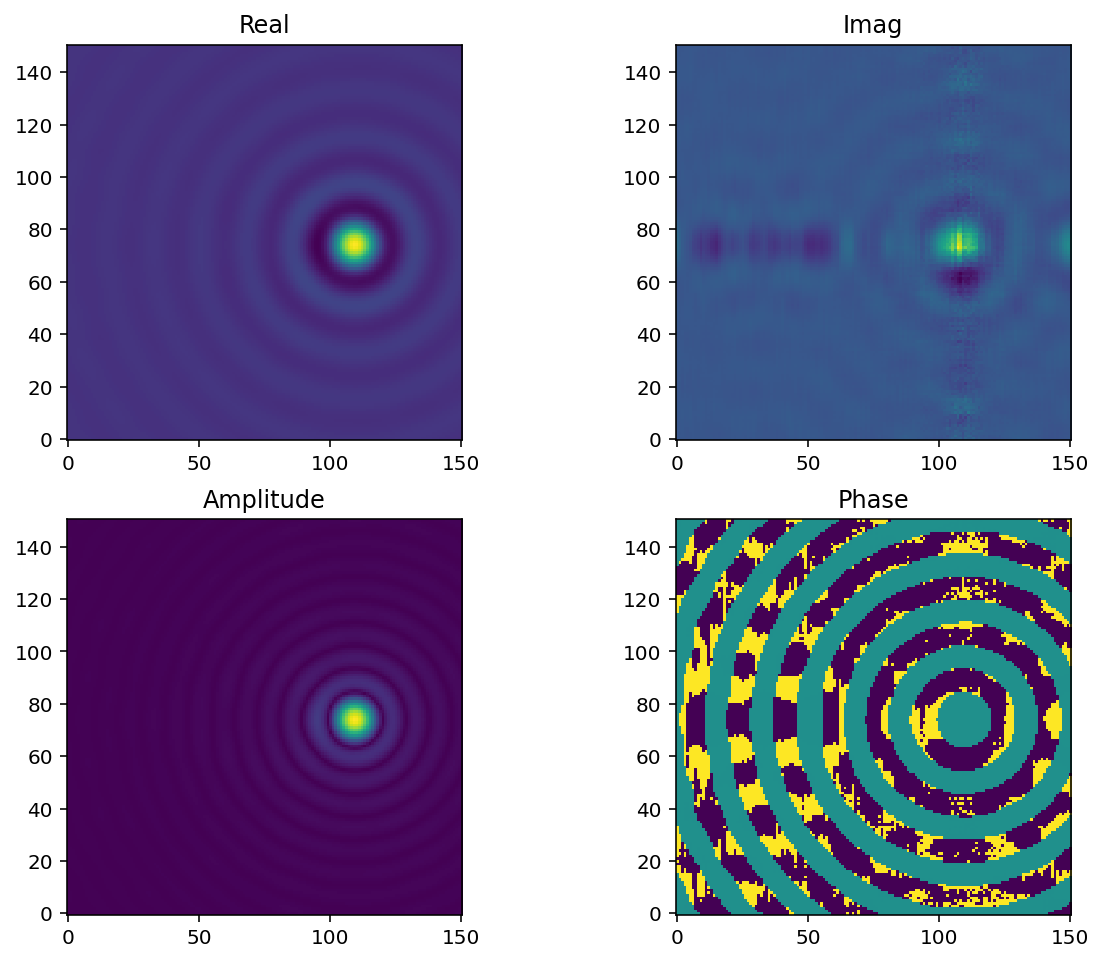

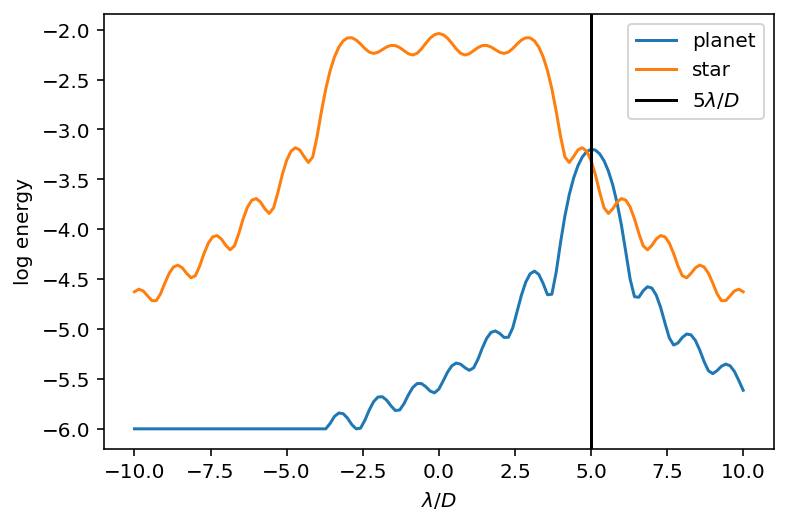

In [15]:
# Q12 answer here

N_lyot = circle_mask(B,int((B.shape[0]-1)/2),int((B.shape[0]-1)/2),.8*.5*dtel)
plt.imshow(N_lyot)
plt.colorbar()
F_planet = coro(A_planet,~m_lyot,N_lyot,nsamp)[-1]
F_star = coro(A_star,~m_lyot,N_lyot,nsamp)[-1]
displC(F_star,151)
displC(F_planet,151)

energy_star = xaxis_energy(F_star,10*nsamp)
energy_planet = xaxis_energy(F_planet,10*nsamp)
log10_star = logit(energy_star)
log10_planet = logit(energy_planet)
plt.plot(x_ap,log10_planet,label='planet')
plt.plot(x_ap,log10_star,label='star')
plt.xlabel('$\lambda/D$')
plt.ylabel('log energy')
plt.axvline(x=5,color='k',label='5$\lambda/D$')
plt.legend()
# Q12 end of answer


---
<span style="  font-size:2em; color: SteelBlue;">Question 3.13</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Overplot `B_star` and `F_star` on the same plot. Estimate by eye the suppression factor of the coronagraph by looking at the peak of the PSFs.**

---

In [ ]:
displC(B_star,151)
displC(F_star,151)

By looking at the peak of the PSFs the suppression factor of the coronagraph: 0.0007546057622641314


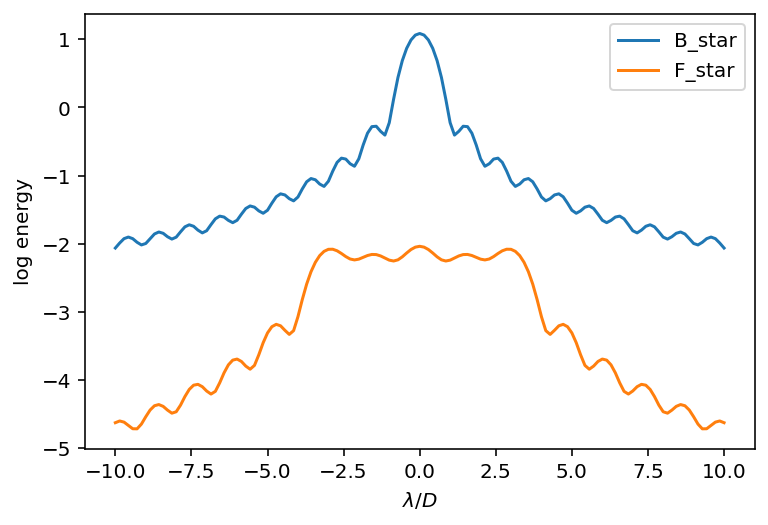

In [16]:
# Q13 answer here

energy_Bstar = xaxis_energy(B_star,10*nsamp)
energy_Fstar =  xaxis_energy(F_star,10*nsamp)
log_Bstar = logit(energy_Bstar)
log_Fstar = logit(energy_Fstar)
plt.plot(x_ap,log_Bstar,label='B_star')
plt.plot(x_ap,log_Fstar,label='F_star')
plt.xlabel('$\lambda/D$')
plt.ylabel('log energy')
plt.legend()
F_suppression = 10**np.max(log_Fstar)/10**np.max(log_Bstar)

# Q13 end of answer

print("By looking at the peak of the PSFs the suppression factor of the coronagraph: {}".format(F_suppression))


---
<span style="  font-size:2em; color: SteelBlue;">Question 3.14</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Overplot `B_planet` and `F_planet`. What has happened to the Airy rings? Why?**

---


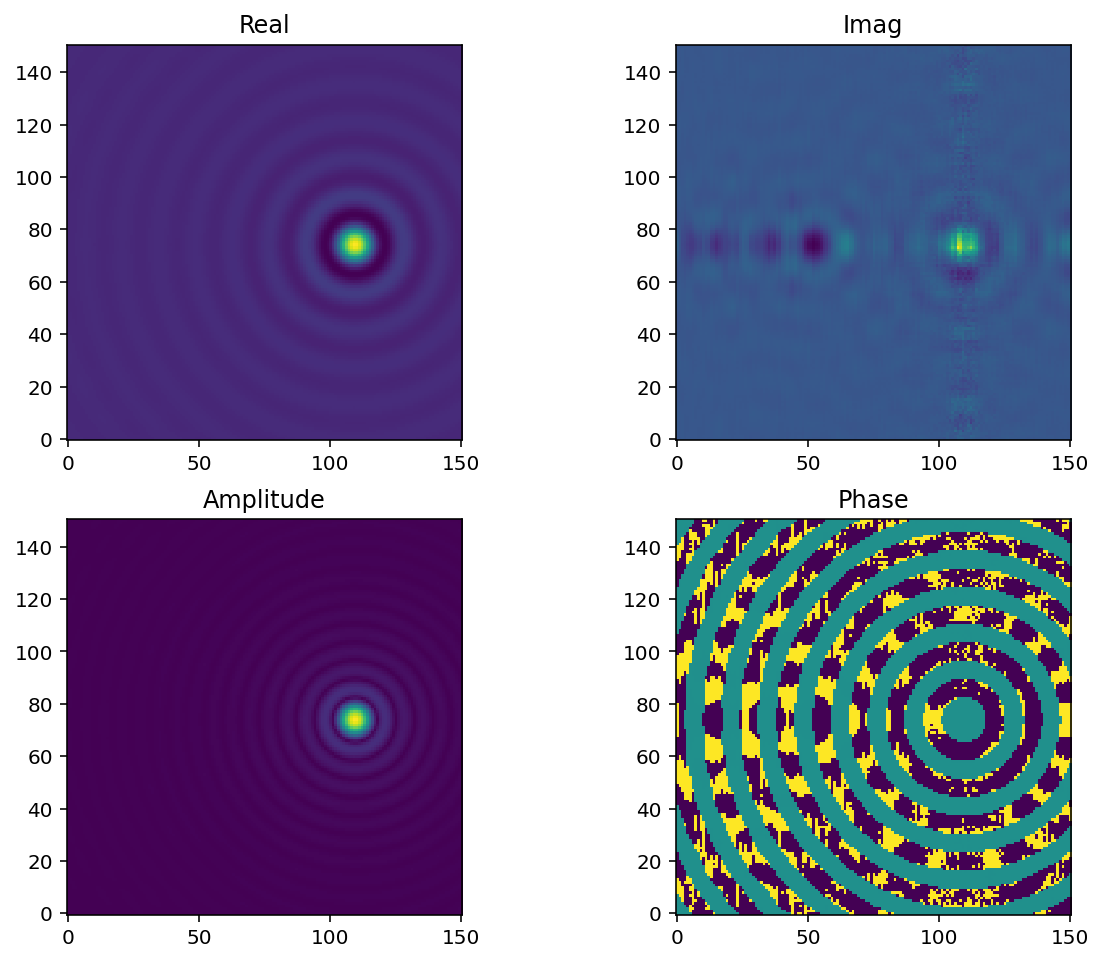

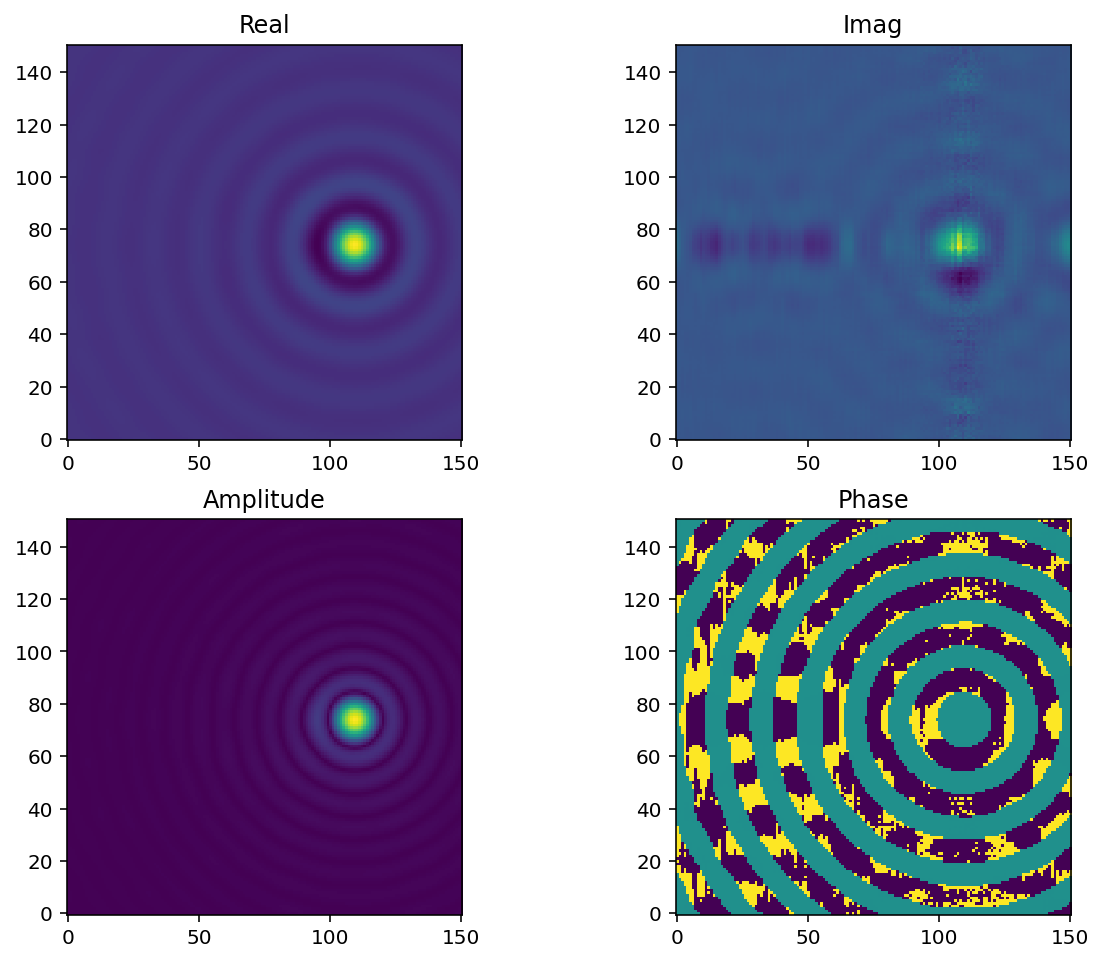

The Airy rings become weaker in intensity, due to the the masking at m.


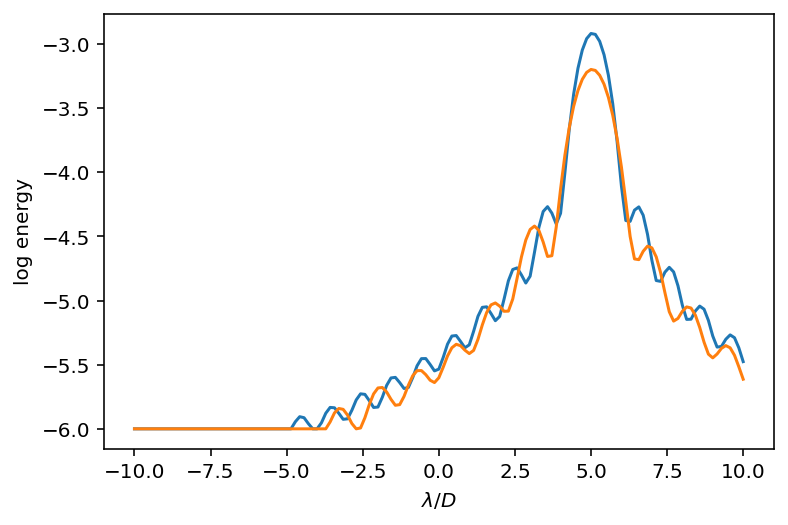

In [27]:
# Q14 answer here

displC(B_planet,151) 
displC(F_planet,151)
energy_Bplanet = xaxis_energy(B_planet,10*nsamp)
energy_Fplanet =  xaxis_energy(F_planet,10*nsamp)
log_Bplanet = logit(energy_Bplanet)
log_Fplanet = logit(energy_Fplanet)
plt.plot(x_ap,log_Bplanet)
plt.plot(x_ap,log_Fplanet)
plt.xlabel('$\lambda/D$')
plt.ylabel('log energy')

# Q14 end of answer

print("The Airy rings become weaker in intensity, due to the the masking at m.") # add your answer to the question here

The star and the planet are incoherent sources with respect to each other, and so the image on the sky is the sum of their separate intensities.

---
<span style="  font-size:2em; color: SteelBlue;">Question 3.15</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Make an intensity image of the star and planet before the coronagraph, and display it with `displC(logit(x),151)`.**

**Make an image after the coronagraph as well. You should be able to see the planet.**

---


/Users/tardis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in log10


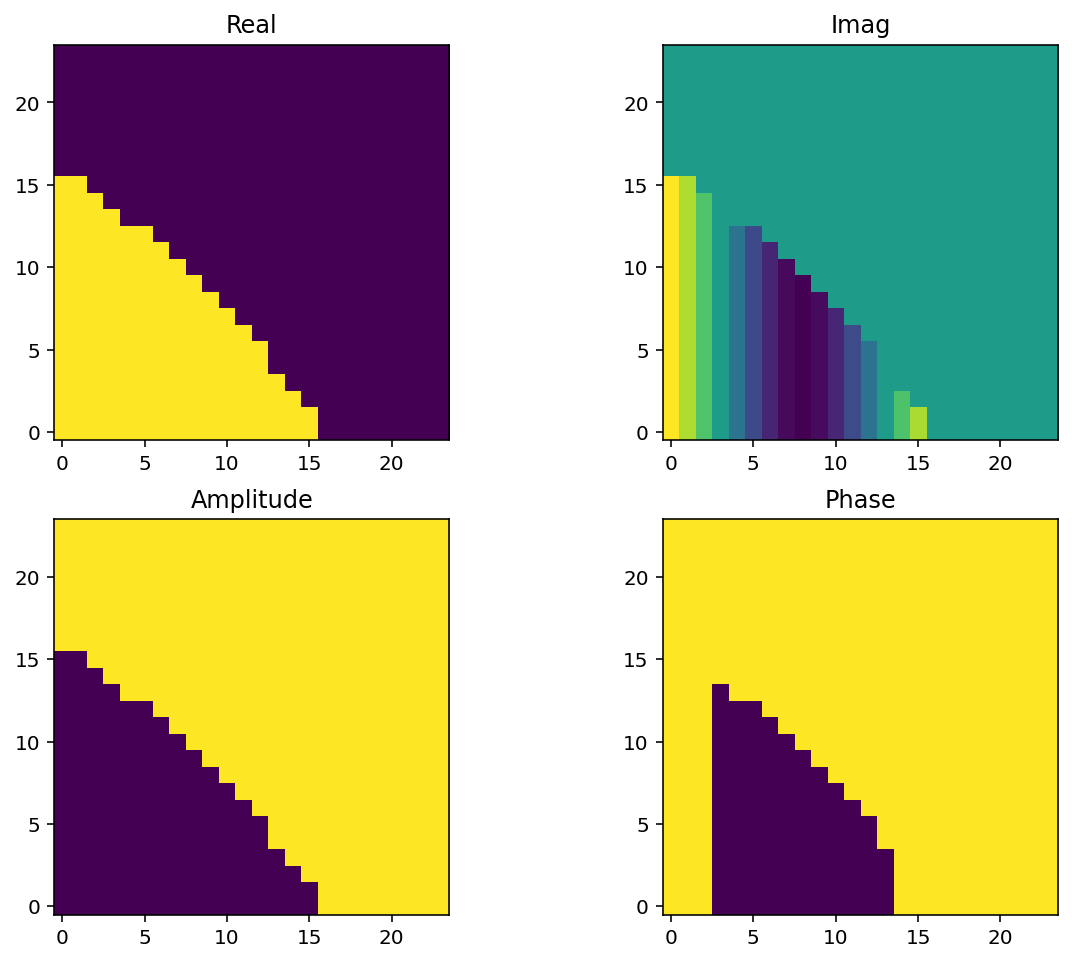

In [18]:
# Q15 answer here

sky = A_star+A_planet
displC(logit(sky),151)


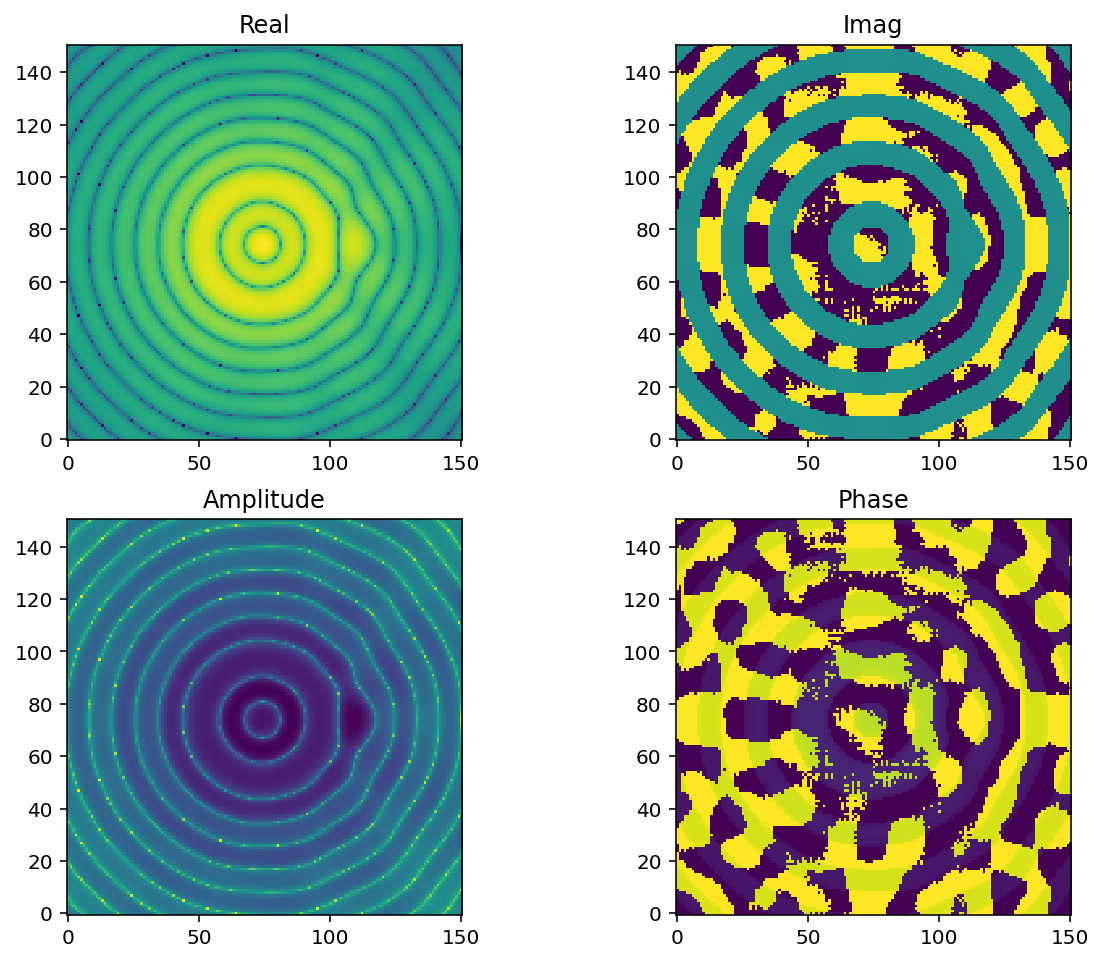

In [19]:

# .... after
sky_coro  = coro(sky,~m_lyot,N_lyot,nsamp)[-1]
displC(logit(sky_coro),151)
# Q15 end of answer

---
<span style="  font-size:2em; color: SteelBlue;">Question 3.16</span> <span style="  font-size:1em; color: SteelBlue;">
(8 points): </span>

**Adjust the Lyot stop size from 0.5 to 1.0 times the diameter of the pupil, and adjust the diameter of the hard-edged stop so that you optimise the brightness of the planet compared to the stellar halo. What are the problems that you find with small Lyot stops?**

--- 

In [20]:
def f(m_Diameter,LyotStopSize):
    m_lyot = circle_mask(B,int((B.shape[0]-1)/2),int((B.shape[0]-1)/2),m_Diameter*nsamp)
    N_lyot = circle_mask(B,int((B.shape[0]-1)/2),int((B.shape[0]-1)/2),LyotStopSize*.5*dtel)
    F_planet = coro(A_planet,~m_lyot,N_lyot,nsamp)[-1]
    F_star = coro(A_star,~m_lyot,N_lyot,nsamp)[-1]
    sky = A_star+A_planet
    sky_coro  = coro(sky,~m_lyot,N_lyot,nsamp)[-1]
    displC(logit(sky_coro),151)
    energy_star = xaxis_energy(F_star,10*nsamp)
    energy_planet = xaxis_energy(F_planet,10*nsamp)
    log10_star = logit(energy_star)
    log10_planet = logit(energy_planet)
    plt.plot(x_ap,log10_planet,label='planet')
    plt.plot(x_ap,log10_star,label='star')
    plt.xlabel('$\lambda/D$')
    plt.ylabel('log energy')
    plt.axvline(x=5,color='k',label='5$\lambda/D$')
    plt.legend()

%run ../week_1/interactive.py

In [24]:
interactive_plot = interactive(f, m_Diameter=(1,7),LyotStopSize=(.5,1.))
interactive_plot

interactive(children=(IntSlider(value=4, description='m_Diameter', max=7, min=1), FloatSlider(value=0.75, desc…

In [26]:
# Q16 answer here

print("Answer to question 16: with decreasing Lyot stop size, the sidelobes of  the star becomes weaker in intensity and closer to zero point. 'm_Diameter' changes the intensity of the wave of the planet and the shape of the wave of the star. At small Lyot stop sizes the Airy rings become open at small radii and harder to differentiate the planet from the star simply by looking at the Amplitude plot.")

# Q16 end of answer

Answer to question 16: with decreasing Lyot stop size, the sidelobes of  the star becomes weaker in intensity and closer to zero point. 'm_Diameter' changes the intensity of the wave of the planet and the shape of the wave of the star. At small Lyot stop sizes the Airy rings become open at small radii and harder to differentiate the planet from the star simply by looking at the Amplitude plot.


---
<span style="  font-size:2em; color: SteelBlue;">Your time has a value as well</span> 
 </span>

---

### How long did this Practicum take?
Please enter the number of hours you spent on this Practicum (including the time spend besides the time spend during the Lecture) below:


Number of hours taken for this practicum: ~ 6 hours.
